In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import ndimage

#image = '/home/cot12/Documents/jup-pads/circle.jpg'
image = r"C:\Users\cory\Documents\boobies.jpg"
#image = '/home/cot12/Documents/jup-pads/rectangle.jpg'
#image = '/home/cot12/Documents/jup-pads/waves.jpeg'
#image = r"C:\Users\cory\Documents\flower.jpeg"
Beginning_image = cv2.imread(image,0) #read image "0" for gray and "1" for colour

def Image_check_x(image):
    p = image.shape[0]
    if ((p+3)/4) != int((p+3)/4):
        if ((p+2)/4) != int((p+2)/4):
            if ((p+1)/4) != int((p+1)/4):
                return p
            else:
                return p+1
        else:
            return p+2
    else:
        return p+3



def Image_check_y(image):
    p = image.shape[1]
    if ((p+3)/4) != int((p+3)/4):
        if ((p+2)/4) != int((p+2)/4):
            if ((p+1)/4) != int((p+1)/4):
                return p
            else:
                return p+1
        else:
            return p+2
    else:
        return p+3
    
    
q = int(Image_check_x(Beginning_image))
u = int(Image_check_y(Beginning_image))
beginning_image = cv2.resize(Beginning_image,(u,q))
s = 3
k = 2 ** (1.0 / s) #kernals
sig = 2.2
kvector = np.array([sig, k*sig, sig*(k**2), sig*(k**3), sig*(k**4), sig*(k**5),sig*(k**6), sig*(k**7), sig*(k**8)])
#kvector = np.array([sig, k*sig, sig*(k**2), sig*(k**3), sig*(k**4), sig*(k**5),sig*(k**6), sig*(k**7), sig*(k**8)])
c = -1
threshold = 1

def gauss_blur(sigma):

    """Function to mimic the 'fspecial' gaussian MATLAB function
    """
    size = 2*np.ceil(3*sigma)+1
    x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
    g = np.exp(-((x**2 + y**2)/(2.0*sigma**2)))
    return g/g.sum()

#pyrlvl[0] = cv2.filter2D(Beginning_image,c, gauss_blur(s,k))
#print (gauss_blur(8,5))
#plt.imshow(filter_image_Gblur3, cmap ='gray')
#cv2.imwrite('/home/cot12/Documents/jup-pads/sky-2.jpg', filter_image_Gblur1)
# detA = (dxx*((dyy * dzz)-(dyz**2))) + (dxy*((dxy*dzz)-(dxz*dyz))) + (dxz*((dxy*dxz)-((dyy*dxz))))

#create image size variant
doubled = cv2.resize((beginning_image), ((2*u),(2*q)))
normal = cv2.resize((doubled),(u,q))
half = cv2.resize((normal), (int(u/2),int(q/2)))
quarter = cv2.resize((half),(int(u/4),int(q/4)))

#create zero layer for pyramid
pyrlvl1 = np.zeros((doubled.shape[0], doubled.shape[1],6))
pyrlvl2 = np.zeros((normal.shape[0], normal.shape[1],6))
pyrlvl3 = np.zeros((half.shape[0], half.shape[1],6))
pyrlvl4 = np.zeros((quarter.shape[0], quarter.shape[1],6))

# create our Gaussian pyramid
for i in range(0,6):
    pyrlvl1[:,:,i] = ndimage.filters.gaussian_filter(doubled, kvector[i]) 
    pyrlvl2[:,:,i] = ndimage.filters.gaussian_filter(normal, kvector[i+1])
    pyrlvl3[:,:,i] = ndimage.filters.gaussian_filter(half, kvector[i+2])
    pyrlvl4[:,:,i] = ndimage.filters.gaussian_filter(quarter,kvector[i+3])

#create zero layer for DoG images 
DoGlvl1 = np.zeros((doubled.shape[0], doubled.shape[1],5))
DoGlvl2 = np.zeros((normal.shape[0], normal.shape[1],5))
DoGlvl3 = np.zeros((half.shape[0], half.shape[1],5))
DoGlvl4 = np.zeros((quarter.shape[0], quarter.shape[1],5))

# create DoG layer
for i in range (0,5):
    DoGlvl1[:,:,i] = pyrlvl1[:,:,i+1] - pyrlvl1[:,:,i]
    DoGlvl2[:,:,i] = pyrlvl2[:,:,i+1] - pyrlvl2[:,:,i]
    DoGlvl3[:,:,i] = pyrlvl3[:,:,i+1] - pyrlvl3[:,:,i]
    DoGlvl4[:,:,i] = pyrlvl4[:,:,i+1] - pyrlvl4[:,:,i]
    
# create zero layer to store extrema location
Exlvl1 = np.zeros((doubled.shape[0], doubled.shape[1],3))
Exlvl2 = np.zeros((normal.shape[0], normal.shape[1],3))
Exlvl3 = np.zeros((half.shape[0], half.shape[1],3))
Exlvl4 = np.zeros((quarter.shape[0], quarter.shape[1],3))

for i in range(1,4):
    for j in range(16, doubled.shape[0] -16):
        for k in range(16, doubled.shape[1]-16):
            if np.absolute(DoGlvl1[j, k, i]) < threshold:
                continue
            maxima = DoGlvl1[j,k,i] > 0
            minima = DoGlvl1[j,k,i] < 0
            for di in range(-1,2):
                for dj in range(-1,2):
                    for dk in range(-1,2):
                        if di == 0 and dj ==0 and dk == 0:
                            continue
                        maxima = maxima and (DoGlvl1[j, k, i] > DoGlvl1[j + dj, k + dk, i + di])
                        minima = minima and (DoGlvl1[j, k, i] < DoGlvl1[j + dj, k + dk, i + di])
                        
                        if not maxima and not minima:
                            break

                    if not maxima and not minima:
                        break

                if not maxima and not minima:
                    break
            if maxima or minima:
                dx = (DoGlvl1[j, k+1, i] - DoGlvl1[j, k-1, i]) * 0.5 / 255
                dy = (DoGlvl1[j+1, k, i] - DoGlvl1[j-1, k, i]) * 0.5 / 255
                dz = (DoGlvl1[j, k, i+1] - DoGlvl1[j, k, i-1]) * 0.5 / 255
                dxx = (DoGlvl1[j, k+1, i] + DoGlvl1[j, k-1, i] - 2 * DoGlvl1[j, k, i]) * 1.0 / 255        
                dyy = (DoGlvl1[j+1, k, i] + DoGlvl1[j-1, k, i] - 2 * DoGlvl1[j, k, i]) * 1.0 / 255          
                dzz = (DoGlvl1[j, k, i+1] + DoGlvl1[j, k, i-1] - 2 * DoGlvl1[j, k, i]) * 1.0 / 255
                dxy = (DoGlvl1[j+1, k+1, i] - DoGlvl1[j+1, k-1, i] - DoGlvl1[j-1, k+1, i] + DoGlvl1[j-1, k-1, i]) * 0.25 / 255 
                dxz = (DoGlvl1[j, k+1, i+1] - DoGlvl1[j, k-1, i+1] - DoGlvl1[j, k+1, i-1] + DoGlvl1[j, k-1, i-1]) * 0.25 / 255 
                dyz = (DoGlvl1[j+1, k, i+1] - DoGlvl1[j-1, k, i+1] - DoGlvl1[j+1, k, i-1] + DoGlvl1[j-1, k, i-1]) * 0.25 / 255  
                
                
                J = np.matrix([[dx], [dy], [dz]])
                DH = np.matrix([[dxx, dxy, dxz], [dxy, dyy, dyz], [dxz, dyz, dzz]])
                detA = (dxx*((dyy * dzz)-(dyz**2))) + (dxy*((dxy*dzz)-(dxz*dyz))) + (dxz*((dxy*dxz)-((dyy*dxz))))
                invDH = np.linalg.pinv(DH)
                
                X_hat = np.dot(invDH,J)
                D_X_hat = DoGlvl1[j,k,i] + (0.5 * np.dot(J,np.transpose(X_hat))) #contast variable
                r = 10.0
                if [(((dxx + dyy) ** 2) * r) < (dxx * dyy - (dxy ** 2)) * (((r + 1) ** 2)) and np.absolute(D_X_hat) < 0.03]:
                    Exlvl1[j, k, i - 1] = 1

for i in range(1,4):
    for j in range(8, normal.shape[0] -8):
        for k in range(8, normal.shape[1]-8):
            if np.absolute(DoGlvl2[j, k, i]) < threshold:
                continue
            maxima = DoGlvl2[j,k,i] > 0
            minima = DoGlvl2[j,k,i] < 0
            for di in range(-1,2):
                for dj in range(-1,2):
                    for dk in range(-1,2):
                        if di == 0 and dj ==0 and dk == 0:
                            continue
                        maxima = maxima and (DoGlvl2[j, k, i] > DoGlvl2[j + dj, k + dk, i + di])
                        minima = minima and (DoGlvl2[j, k, i] < DoGlvl2[j + dj, k + dk, i + di])
                        
                        if not maxima and not minima:
                            break

                    if not maxima and not minima:
                        break

                if not maxima and not minima:
                    break
            if maxima or minima:
                dx = (DoGlvl2[j, k+1, i] - DoGlvl2[j, k-1, i]) * 0.5 / 255
                dy = (DoGlvl2[j+1, k, i] - DoGlvl2[j-1, k, i]) * 0.5 / 255
                dz = (DoGlvl2[j, k, i+1] - DoGlvl2[j, k, i-1]) * 0.5 / 255
                dxx = (DoGlvl2[j, k+1, i] + DoGlvl2[j, k-1, i] - 2 * DoGlvl2[j, k, i]) * 1.0 / 255        
                dyy = (DoGlvl2[j+1, k, i] + DoGlvl2[j-1, k, i] - 2 * DoGlvl2[j, k, i]) * 1.0 / 255          
                dzz = (DoGlvl2[j, k, i+1] + DoGlvl2[j, k, i-1] - 2 * DoGlvl2[j, k, i]) * 1.0 / 255
                dxy = (DoGlvl2[j+1, k+1, i] - DoGlvl2[j+1, k-1, i] - DoGlvl2[j-1, k+1, i] + DoGlvl2[j-1, k-1, i]) * 0.25 / 255 
                dxz = (DoGlvl2[j, k+1, i+1] - DoGlvl2[j, k-1, i+1] - DoGlvl2[j, k+1, i-1] + DoGlvl2[j, k-1, i-1]) * 0.25 / 255 
                dyz = (DoGlvl2[j+1, k, i+1] - DoGlvl2[j-1, k, i+1] - DoGlvl2[j+1, k, i-1] + DoGlvl2[j-1, k, i-1]) * 0.25 / 255  
                
                
                J = np.matrix([[dx], [dy], [dz]])
                DH = np.matrix([[dxx, dxy, dxz], [dxy, dyy, dyz], [dxz, dyz, dzz]])
                detA = (dxx*((dyy * dzz)-(dyz**2))) + (dxy*((dxy*dzz)-(dxz*dyz))) + (dxz*((dxy*dxz)-((dyy*dxz))))
                invDH = np.linalg.pinv(DH)
                X_hat = np.dot(invDH,J)
                D_X_hat = DoGlvl2[j,k,i] + (0.5 * np.dot(J,np.transpose(X_hat))) #contast variable
                r = 10.0
                if [(((dxx + dyy) ** 2) * r) < (dxx * dyy - (dxy ** 2)) * (((r + 1) ** 2)) and np.absolute(D_X_hat) < 0.03]:
                    Exlvl2[j, k, i - 1] = 1
                    
for i in range(1,4):
    for j in range(4, half.shape[0] -4):
        for k in range(4, half.shape[1]-4):
            if np.absolute(DoGlvl3[j, k, i]) < threshold:
                continue
            maxima = DoGlvl3[j,k,i] > 0
            minima = DoGlvl3[j,k,i] < 0
            for di in range(-1,2):
                for dj in range(-1,2):
                    for dk in range(-1,2):
                        if di == 0 and dj ==0 and dk == 0:
                            continue
                        maxima = maxima and (DoGlvl3[j, k, i] > DoGlvl3[j + dj, k + dk, i + di])
                        minima = minima and (DoGlvl3[j, k, i] < DoGlvl3[j + dj, k + dk, i + di])
                        
                        if not maxima and not minima:
                            break

                    if not maxima and not minima:
                        break

                if not maxima and not minima:
                    break
            if maxima or minima:
                dx = (DoGlvl3[j, k+1, i] - DoGlvl3[j, k-1, i]) * 0.5 / 255
                dy = (DoGlvl3[j+1, k, i] - DoGlvl3[j-1, k, i]) * 0.5 / 255
                dz = (DoGlvl3[j, k, i+1] - DoGlvl3[j, k, i-1]) * 0.5 / 255
                dxx = (DoGlvl3[j, k+1, i] + DoGlvl3[j, k-1, i] - 2 * DoGlvl3[j, k, i]) * 1.0 / 255        
                dyy = (DoGlvl3[j+1, k, i] + DoGlvl3[j-1, k, i] - 2 * DoGlvl3[j, k, i]) * 1.0 / 255          
                dzz = (DoGlvl3[j, k, i+1] + DoGlvl3[j, k, i-1] - 2 * DoGlvl3[j, k, i]) * 1.0 / 255
                dxy = (DoGlvl3[j+1, k+1, i] - DoGlvl3[j+1, k-1, i] - DoGlvl3[j-1, k+1, i] + DoGlvl3[j-1, k-1, i]) * 0.25 / 255 
                dxz = (DoGlvl3[j, k+1, i+1] - DoGlvl3[j, k-1, i+1] - DoGlvl3[j, k+1, i-1] + DoGlvl3[j, k-1, i-1]) * 0.25 / 255 
                dyz = (DoGlvl3[j+1, k, i+1] - DoGlvl3[j-1, k, i+1] - DoGlvl3[j+1, k, i-1] + DoGlvl3[j-1, k, i-1]) * 0.25 / 255  
                
                
                J = np.matrix([[dx], [dy], [dz]])
                DH = np.matrix([[dxx, dxy, dxz], [dxy, dyy, dyz], [dxz, dyz, dzz]])
                detA = (dxx*((dyy * dzz)-(dyz**2))) + (dxy*((dxy*dzz)-(dxz*dyz))) + (dxz*((dxy*dxz)-((dyy*dxz))))
                invDH = np.linalg.pinv(DH)
                
                X_hat = np.dot(invDH,J)
                D_X_hat = DoGlvl3[j,k,i] + (0.5 * np.dot(J,np.transpose(X_hat))) #contast variable
                r = 10.0
                if [(((dxx + dyy) ** 2) * r) < (dxx * dyy - (dxy ** 2)) * (((r + 1) ** 2)) and np.absolute(D_X_hat) < 0.03]:
                    Exlvl3[j, k, i - 1] = 1
        
for i in range(1,4):
    for j in range(2, quarter.shape[0] -2):
        for k in range(2, quarter.shape[1]-2):
            if np.absolute(DoGlvl4[j, k, i]) < threshold:
                continue
            maxima = DoGlvl4[j,k,i] > 0
            minima = DoGlvl4[j,k,i] < 0
            for di in range(-1,2):
                for dj in range(-1,2):
                    for dk in range(-1,2):
                        if di == 0 and dj ==0 and dk == 0:
                            continue
                        maxima = maxima and (DoGlvl4[j, k, i] > DoGlvl4[j + dj, k + dk, i + di])
                        minima = minima and (DoGlvl4[j, k, i] < DoGlvl4[j + dj, k + dk, i + di])
                        
                        if not maxima and not minima:
                            break

                    if not maxima and not minima:
                        break

                if not maxima and not minima:
                    break
            if maxima or minima:
                dx = (DoGlvl4[j, k+1, i] - DoGlvl4[j, k-1, i]) * 0.5 / 255
                dy = (DoGlvl4[j+1, k, i] - DoGlvl4[j-1, k, i]) * 0.5 / 255
                dz = (DoGlvl4[j, k, i+1] - DoGlvl4[j, k, i-1]) * 0.5 / 255
                dxx = (DoGlvl4[j, k+1, i] + DoGlvl4[j, k-1, i] - 2 * DoGlvl4[j, k, i]) * 1.0 / 255        
                dyy = (DoGlvl4[j+1, k, i] + DoGlvl4[j-1, k, i] - 2 * DoGlvl4[j, k, i]) * 1.0 / 255          
                dzz = (DoGlvl4[j, k, i+1] + DoGlvl4[j, k, i-1] - 2 * DoGlvl4[j, k, i]) * 1.0 / 255
                dxy = (DoGlvl4[j+1, k+1, i] - DoGlvl4[j+1, k-1, i] - DoGlvl4[j-1, k+1, i] + DoGlvl4[j-1, k-1, i]) * 0.25 / 255 
                dxz = (DoGlvl4[j, k+1, i+1] - DoGlvl4[j, k-1, i+1] - DoGlvl4[j, k+1, i-1] + DoGlvl4[j, k-1, i-1]) * 0.25 / 255 
                dyz = (DoGlvl4[j+1, k, i+1] - DoGlvl4[j-1, k, i+1] - DoGlvl4[j+1, k, i-1] + DoGlvl4[j-1, k, i-1]) * 0.25 / 255  
                
                
                J = np.matrix([[dx], [dy], [dz]])
                DH = np.matrix([[dxx, dxy, dxz], [dxy, dyy, dyz], [dxz, dyz, dzz]])
                detA = (dxx*((dyy * dzz)-(dyz**2))) + (dxy*((dxy*dzz)-(dxz*dyz))) + (dxz*((dxy*dxz)-((dyy*dxz))))
                invDH = np.linalg.pinv(DH)
                
                X_hat = np.dot(invDH,J)
                D_X_hat = DoGlvl4[j,k,i] + (0.5 * np.dot(J,np.transpose(X_hat))) #contast variable
                r = 10.0
                if [(((dxx + dyy) ** 2) * r) < (dxx * dyy - (dxy ** 2)) * (((r + 1) ** 2)) and np.absolute(D_X_hat) < 0.03]:
                    Exlvl4[j, k, i - 1] = 1
                    
print("Number of extrema in first octave: %d" % np.sum(Exlvl1))
print("Number of extrema in second octave: %d" % np.sum(Exlvl2))
print("Number of extrema in third octave: %d" % np.sum(Exlvl3))
print("Number of extrema in fourth octave: %d" % np.sum(Exlvl4))

extr_sum = int(np.sum(Exlvl1)) + int(np.sum(Exlvl2)) + int(np.sum(Exlvl3)) + int(np.sum(Exlvl4))

keypoints = np.zeros((extr_sum, 4)) 

dump1 = np.zeros((normal.shape[0], normal.shape[1],3))

Number of extrema in first octave: 83089
Number of extrema in second octave: 12988
Number of extrema in third octave: 2272
Number of extrema in fourth octave: 468


In [6]:
features_DoGlvl1 = cv2.resize((DoGlvl1), (int(u/2),int(q/2)))
features_DoGlvl2 = DoGlvl2
features_DoGlvl3 = cv2.resize((DoGlvl3), (int(2*u),int(2*q)))
features_DoGlvl4 = cv2.resize((DoGlvl4), (int(4*u),int(4*q)))

In [7]:
for i in range(1,4):
    for j in range(0, normal.shape[0] -1):
        for k in range(0, normal.shape[1]-1):
            if features_DoGlvl3[j,k,i]>0:
                dump1[j,k,i-1] == features_DoGlvl3[j,k,i]
            else:
                dump1[j,k,i-1] == features_DoGlvl3[j,k,i]

In [8]:
cv2.imwrite(r"C:\Users\cory\Documents\mamograms\breast-MLO1-featdump1.jpg",dump1[j,k,i-1])

True

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


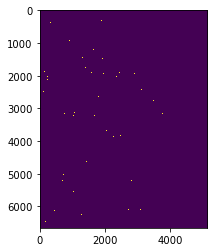

In [104]:
features_Exlvl1 = 255*Exlvl1
print(features_Exlvl1[:,:,0])
plt.imshow(features_Exlvl1[:,:,0])
plt.show()

In [100]:
cv2.imwrite(r"C:\Users\cory\Documents\mamograms\breast-MLO1-featExlvl1-lvl0.jpg",features_Exlvl2[:,:,0])

True

In [ ]:
radius = 2
thickness = 1
color = (255, 0, 0)
for i in range(int(np.sum(Exlvl1)), int(keypoints.shape[0])):
    center_coordinates = (int(keypoints[i,0]),int(keypoints[i,1]))
    cv2.circle(beginning_image, center_coordinates, radius, color, thickness)
    cv2.imwrite(r"C:\Users\cory\Documents\boob-test-features.jpg",beginning_image)